In [18]:
import numpy as np
import pandas as pd
import os
from scipy.optimize import linprog
import cvxpy as cp
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv(os.path.join('data', 'investment_data.csv'))
df

,yield,risk,fee,threshold
s1,0.28,0.025,0.010,103
s2,0.21,0.015,0.020,198
s3,0.23,0.055,0.045,52
s4,0.25,0.026,0.065,40


In [20]:
# 添加银行存款一列
bank = pd.DataFrame({'yield': 0.05, 'risk': 0, 'fee': 0, 'threshold': 0}, index=['bank'])
df = df.append(bank)
df

C:\Users\Sunlight\AppData\Local\Temp\ipykernel_10440\2670357807.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(bank)


,yield,risk,fee,threshold
s1,0.28,0.025,0.010,103
s2,0.21,0.015,0.020,198
s3,0.23,0.055,0.045,52
s4,0.25,0.026,0.065,40
bank,0.05,0.000,0.000,0


In [21]:
data = df.values
r, q, p, u = data.T
r, q, p, u

(array([0.28, 0.21, 0.23, 0.25, 0.05]),
 array([0.025, 0.015, 0.055, 0.026, 0.   ]),
 array([0.01 , 0.02 , 0.045, 0.065, 0.   ]),
 array([103., 198.,  52.,  40.,   0.]))

## 模型一

风险小于给定水平，最大化收益。

$$
\begin{align}
&\max \sum_{i=0}^n (r_i - p_i) x_i  \\
&\text{s.t.}
\begin{cases}
q_i x_i / M \le a, & i = 1, \dots, n; \\
\sum_{i = 0}^n (1 + p_i) x_i = M, & i = 0, \dots, n; \\
x_i \ge 0, & i = 0, \dots. n
\end{cases}
\end{align}
$$

In [22]:
n = 5 # 总变量数
c = p - r

# 定义优化函数
def best_investment(a):
    # 生成对角矩阵
    Au = np.diag(q)
    bu = np.full(n, a)
    Aeq = [1 + p]
    beq = [1]
    L = [0] * n
    U = [None] * n
    bounds = list(zip(L, U))

    res = linprog(c, Au, bu, Aeq, beq, bounds)
    t_yield = - res.fun
    return t_yield

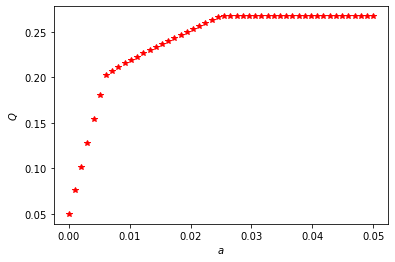

In [23]:
points = [(aa, best_investment(aa)) for aa in np.linspace(0, 0.05, 50, endpoint=True)]
# 将散点转化为两个列表再输入
plt.xlabel('$a$')
plt.ylabel('$Q$')
plt.plot(*zip(*points), 'r*')

## 模型二：固定收益，极小化风险

技巧：对于形如$\min \max_{1 \le i \le n} a_i x_i$的目标，引入增补变量$y$，将目标改为$\min y$，添加条件$a_i x_i \le y$，即可化为一般的线性规划问题。

$$

$$

In [24]:
def minimized_risk(Q):
    c = np.concatenate([np.zeros(n), [1]])
    Au1 = np.concatenate([np.diag(q), -np.ones(n).reshape(n, 1)], axis=1)
    Au2 = np.concatenate([p - r, [0]]).reshape(1, -1)
    Au = np.concatenate([Au1, Au2], axis=0)
    bu1 = np.zeros(n)
    bu2 = np.array([-Q])
    bu = np.concatenate([bu1, bu2])

    Aeq = np.concatenate([1 + p, [0]]).reshape(-1, n + 1)
    beq = [1]

    L = [0] * n + [None]
    U = [None] * (n + 1)
    bounds = list(zip(L, U))

    res = linprog(c, Au, bu, Aeq, beq, bounds)
    return res.fun


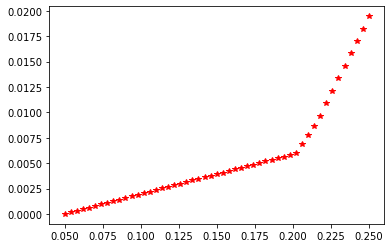

In [25]:
points = [(Q, minimized_risk(Q)) for Q in np.linspace(0.05, 0.25, 51, endpoint=True)]

plt.plot(*zip(*points), 'r*')

使用`cvxpy`则不再需要线性化，直接输入问题即可。

注意`cvxpy`三种乘法的功能不同：

* 星号`*`用于数乘
* AT符号`@`用于矩阵乘法和矩阵向量乘法
* `cvxpy.multiply`用于矩阵的Hadamard积（逐元素相乘）

In [26]:
# Use cvxpy

Q = 0.1

x = cp.Variable(n)
obj = cp.Minimize(cp.max(cp.multiply(q, x)))
con = [
    (r - p) @ x >= Q,
    (1 + p) @ x == 1,
    x >= 0
]
prob = cp.Problem(obj, con)
prob.solve()
x.value

array([0.07834654, 0.13057757, 0.03561206, 0.07533321, 0.67023639])

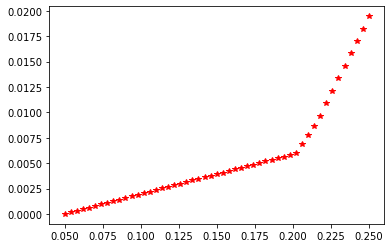

In [27]:
def minimized_risk2(Q):
    x = cp.Variable(n)
    obj = cp.Minimize(cp.max(cp.multiply(q, x)))
    con = [
        (r - p) @ x >= Q,
        (1 + p) @ x == 1,
        x >= 0
    ]
    prob = cp.Problem(obj, con)
    prob.solve()
    return prob.value, x.value

Qs = list(np.linspace(0.05, 0.25, 51, endpoint=True))
risks = [minimized_risk2(Q)[0] for Q in Qs]

plt.plot(Qs, risks, 'r*')
plt.show()

## 模型三：收益和风险加权

In [28]:
n = 5

def weighted_investment(risk_weight):
    w = risk_weight
    c = np.concatenate([(1 - w) * (p - r), [w]])
    Au = np.concatenate([np.diag(q), -np.ones(n).reshape(-1, 1)], axis=1)
    bu = np.zeros(n)
    Aeq = np.concatenate([1 + p, [0]]).reshape(1, -1)
    beq = [1]

    L = [0] * n + [None]
    U = [None] * (n + 1)
    bounds = list(zip(L, U))

    res = linprog(c, Au, bu, Aeq, beq, bounds)
    return - res.fun, res.x

In [29]:
weights = np.linspace(0, 1, 1001, endpoint=True)
f_v_tuples = [weighted_investment(w) for w in weights]
funcs, values = zip(*f_v_tuples)
yields = [(r - p) @ value[:-1] for value in values]
risks = [np.max(q @ value[:-1]) for value in values]

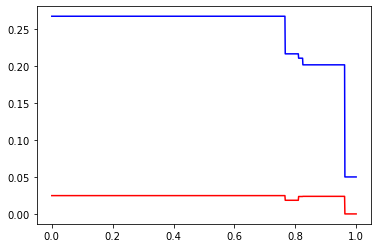

In [30]:
plt.plot(weights, risks, color='r')
plt.plot(weights, yields, color='b')
# plt.plot(weights, np.max(q * np.array(values)))
plt.show()

In [31]:
# use cvxpy
x = cp.Variable(n)
s = 0.1
obj = cp.Minimize(s * cp.max(cp.multiply(q, x)) - (1 - s) * ((r - p) @ x))
con = [(1 + p) @ x == 1, x >= 0]
prob = cp.Problem(obj, con)
prob.solve()
(r - p) @ x.value

0.2673267326536395

In [32]:
def weighted_investment2(s):
    x = cp.Variable(n)
    obj = cp.Minimize(s * cp.max(cp.multiply(q, x)) - (1 - s) * ((r - p) @ x))
    con = [(1 + p) @ x == 1, x >= 0]
    prob = cp.Problem(obj, con)
    prob.solve()
    return x.value

In [33]:
s = np.linspace(0, 1, 1001, endpoint=True)
x = [weighted_investment2(ss) for ss in s]
yields = [(r - p) @ xx for xx in x]
risks = [np.max(q * xx) for xx in x]

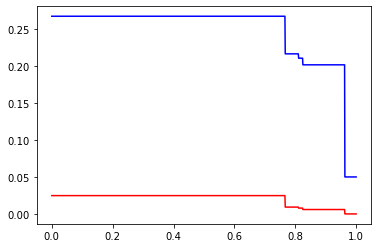

In [34]:
plt.plot(s, yields, color='b')
plt.plot(s, risks, color='r')
plt.show()

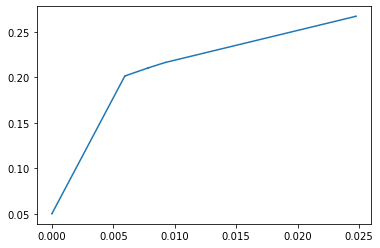

In [36]:
plt.plot(risks, yields)
plt.show()